# Descripción de la prueba

El planteamiento de esta prueba persigue evaluar de manera genérica 3 tipos de habilidades requeridas para esta posición:

* Manejo de objetos estructurados en Python (OOP):
* Obtención y estructuración de datos provenientes de diferentes recursos online; para este notebook, utilizaremos una test-web -> [http://quotes.toscrape.com/js/](http://quotes.toscrape.com/js/)
* Análisis descriptivo básico de los datos obtenidos

Las respuestas a las cuestiones planteadas en cada apartado deben realizarse en las celdas indicadas a tal efecto.

# Módulos requeridos para la ejecución de la prueba

A parte de los paquetes importados por defecto, puede utilizarse cualquier otro, como selenium, scrapy, etc.
Es posible que debas instalar alguno de los módulos aquí reflejados.

In [1]:
# Added imports
#    Part 1
import sys
from typing import List, Set, Any, Union, Optional
from urllib.parse import urljoin, urlsplit
#    Part 2
import itertools
from collections import Counter

# Default imports
import pandas as pd
import json
import re
import regex
import requests
from hashlib import sha256
from bs4 import BeautifulSoup
from datetime import datetime

# 1 - Creación de un objeto Scraper


Crear una **clase child** denominada `QuoteScraper`, que herede todos sus métodos y atributos del objeto `BeautifulSoup`, y que incorpore las siguientes características adicionales:

1. Cada instancia de esta clase admitirá 2 argumentos como entrada:
    * `website` -> Argumento **obligatorio**. Tipo string. Hará referencia al sitio web objeto de scraping.
    * `max_pages` -> Argumento **optativo** (valor por defecto None). Tipo entero mayor o igual a 1. Hará referencia a la cantidad máxima de páginas que se almacenará en la memoria. En caso de no introducirse dicho valor, tomará toda la paginación completa.
    
   Será necesario implementar un chequeo de los tipos de entrada, de manera que si el usuario introduce un tipo erróneo para algún argumento se devuelva un error previamente definido por nosotros: por ejemplo, al tratar de introducir en el argumento `website` un número flotante, se obtendrá un `ScraperArgumentError` con un mensaje al gusto.

2. Las instancias de este objeto tendrán 4 atributos **read_only** añadidos, cuya funcionalidad debemos implementar siguiendo estas pautas:

    * `quotes_list` -> Es una **lista** cuyos items son diccionarios de Python. Cada uno de estos diccionarios se compondrá de 3 campos, a saber: "tag_list", "author" y "quote_text", siguiendo una estructura clave-valor similar a la que se aprecia en la siguiente imagen de ejemplo.
    
    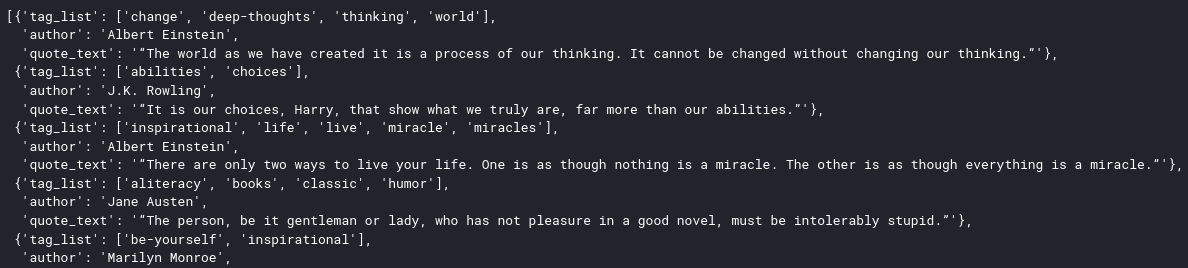
    
    * `website` -> Se trata de un **string** cuyo contenido es la dirección de la web objetivo.
    * `links` -> Consiste en una **lista** con todos aquellos enlaces (hyperlinks) a **webs externas**
    * `timestamp` -> Es un **string** que contiene una marca temporal del momento en que la instancia es creada. Un formato de ejemplo podría ser: '2021-03-29 23:45:32'
    
   Al tratarse de argumentos read_only, su contenido no puede ser modificado por el usuario (el programa arrojará un `AttributeError` al tratar de asignarles un valor)
    
3. La representación por pantalla del objeto `QuoteScraper` debe ser de la forma:

```
ScraperObject: http://quotes.toscrape.com/js/
```

4. Cuando se realice un print del objeto en una celda, queremos mostrar por pantalla la respuesta del método `prettify`, incorporado en `BeautifulSoup` (ver [https://www.crummy.com/software/BeautifulSoup/bs4/doc/#pretty-printing](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#pretty-printing)), en alusión a la última página parseada (según el argumento `max_pages`)


*Ayuda: Comando regex útil para buscar patrones [] de manera recursiva ->* `(\[(?:[^][]*|(?1))*\])`

PD: Documentar debidamente los métodos empleados. Se valorará tanto la concisión en el código, como su legibilidad y generalidad.

In [2]:
# DEFINIR AQUÍ EL ERROR PROPIO ScraperArgumentError

"""
In all the code of this notebook, due to the variety of websites as inputs, I have taken a defensive programming approach.
Also I try to follow good coding practices.

I consider, taking into account the KISS principle, that the implemented solution related to the custom exception is too complex for this little exercise,
but I want to build a more elaborate solution to show my knowledge. 
If it was a real exercise, I would use the following custom exception and use it with custom error messages:

class ScraperArgumentError(TypeError):
    '''Raise when argument types of my scraper are wrong'''
"""


class ScraperArgumentError(TypeError):
    '''Raise when argument types of my scraper are wrong'''

    def __init__(self, arg: Optional[Any] = None, desired_type: Optional[type] = None, msg: Optional[str] = None) -> None:
        self.arg = arg
        self.desired_type = desired_type
        self.msg = msg

    def __str__(self) -> str:
        if self.msg is not None:
            return self.msg
        elif self.arg is not None and self.desired_type is not None:
            return f'must be {self.desired_type.__name__}, not {type(self.arg).__name__}'
        else:
            raise ValueError('Combination of arguments passed wrong')


def check_type(var: Any, desired_type: type) -> None:
    if type(var) is not desired_type:
        raise ScraperArgumentError(var, desired_type)

In [3]:
# DEFINIR AQUÍ LA CLASE QuoteScraper

class QuoteScraper(BeautifulSoup):
    '''
    When accessing attributes, it returns None in unexpected behaviour instead of raise an exception (it could be changed depending on how this class is to be used)
    '''

    def __init__(self, website: str, max_pages: Optional[int] = None) -> None:
        check_type(website, str)

        if max_pages is not None:
            check_type(max_pages, int)
            if max_pages < 1:
                raise ScraperArgumentError(
                    msg='max_pages is not greater or equal than 1'
                )

        self._website = website
        self._max_pages = max_pages

        self._timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

        self.page = requests.get(website)
        # No need to create another instance
        # self.soup = BeautifulSoup(self.page.content, 'html.parser')
        super().__init__(self.page.content, 'html.parser')

        # Initialize variables first used in methods outside the constructor, for clarity
        self._quotes_list = None
        self._links = None
        self._soup_last_page_parsed = None

    def __repr__(self) -> str:
        return f'ScraperObject: {self.website}'

    def __str__(self) -> Union[str, None]:
        if self._soup_last_page_parsed is None:
            parsed_correctly = self.parse_web()
            if not parsed_correctly:
                return

        return self._soup_last_page_parsed.prettify()

    @property
    def quotes_list(self) -> Union[List[dict], None]:
        if self._quotes_list is None:
            parsed_correctly = self.parse_web()
            if not parsed_correctly:
                return

        return self._quotes_list

    @property
    def links(self) -> Union[List[str], None]:
        if self._links is None:
            parsed_correctly = self.parse_web()
            if not parsed_correctly:
                return

        return self._links

    @property
    def website(self) -> str:
        return self._website

    @property
    def timestamp(self) -> str:
        return self._timestamp

    def parse_web(self) -> Union[bool, None]:
        '''
        Due to loading a browser is expensive, we extract quotes reading its JSON text and converting it to Python objects 
        To navigate to the next pages we looking for the class 'pager' and its subclass 'next', intended to be more decoupled and fault tolerant'

        Returns None in unexpected behaviour, True otherwise
        '''

        def get_page_quotes(soup: BeautifulSoup) -> Union[List[dict], None]:
            script_tag = soup.find('script', src=None)
            if script_tag is None:
                print('Cannot find script tag', file=sys.stderr)
                return

            pattern = 'var data =(.+?);\n'
            page_raw_data = re.findall(pattern, script_tag.string, re.S)
            if page_raw_data is None:
                print('Cannot find var data in the script tag', file=sys.stderr)
                return

            page_quotes = json.loads(page_raw_data[0])

            # Rename dict keys and remove unnecessary data from author
            page_quotes = [{'tag_list': quote['tags'], 'author': quote['author']['name'], 'quote_text': quote['text']}
                           for quote in page_quotes]

            return page_quotes

        def get_external_links(soup: BeautifulSoup, exclude_url: str) -> Set[str]:
            '''
            Externals links are considered links that start with 'http' or 'www' and do not contain the domain name (netloc) of the url to exclude, i.e. the internal url
            '''
            # Built-in function in Python 3.9+
            def remove_prefix(text, prefix):
                return text[len(prefix):] if text.startswith(prefix) else text

            split_url = urlsplit(exclude_url)
            # To make the regex works as expected (edge case)
            exclude_netloc_without_prefix = remove_prefix(
                split_url.netloc, 'www.')

            external_links = set()
            # Finds all links that start with 'http' or 'www' that do not contain the current URL netloc
            external_links_regex = f'^(http|www)((?!{re.escape(exclude_netloc_without_prefix)}).)*$'
            for link in soup.find_all('a', {'href': re.compile(external_links_regex)}):
                if link['href'] is not None:
                    external_links.add(link['href'])
            return external_links

        # Variables initialization
        all_quotes = []
        all_links = set()
        n_pages_parsed = 0

        current_page = self.page
        current_soup = self

        while True:
            if (page_quotes := get_page_quotes(current_soup)) is None:
                # Propagate error
                return
            all_quotes += page_quotes
            all_links |= get_external_links(current_soup, self.website)
            n_pages_parsed += 1
            # Alternative more general for python 3.5+
            # all_quotes = [*all_quotes, *page_quotes]
            # all_links = {*all_links, *get_external_links(current_soup, self.website)}

            pager_tag = current_soup.find(class_='pager')
            if pager_tag is None:
                print('Cannot find tag with class pager', file=sys.stderr)
                return

            pager_next_tag = pager_tag.find(class_='next')
            # All pages parsed (next not found) or max pages reached
            if pager_next_tag is None or (self._max_pages is not None and n_pages_parsed >= self._max_pages):
                break

            tag_with_href = pager_next_tag.find(href=True)
            if tag_with_href is None:
                print('Cannot find tag with href attribute', file=sys.stderr)
                return

            next_page_href = tag_with_href['href']
            next_page_url = urljoin(current_page.url, next_page_href)

            # Update variables
            current_page = requests.get(next_page_url)
            current_soup = BeautifulSoup(current_page.content, 'html.parser')

        # Store list in memory to not calculate it again the following times the attribute is accessed, assuming this is the desired performance
        self._quotes_list = all_quotes
        self._links = list(all_links)
        self._soup_last_page_parsed = current_soup

        return True

In [4]:
# NO MODIFICAR EL CONTENIDO DE ESTA CELDA; SIMPLEMENTE EJECUTARLA

soup = QuoteScraper("http://quotes.toscrape.com/js/")

# 2 - Análisis estadístico

Crear un objeto DataFrame, almacenado en una variable denominada `df`, a partir de los datos obtenidos, recogidos en el atributo `quotes_list`, tal y como se muestra en la siguiente imágen:

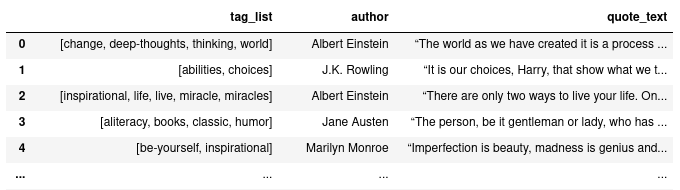

Con ello, responder a las siguientes cuestiones:

1. ¿Cuál es el autor con mayor número de citas? ¿y el segundo mayor?

2. ¿Cuál es el tag que aparece mayor número de veces?

3. ¿Cuántas veces aparece la etiqueta "humor" siendo la única etiqueta? (sin compañía de otras)

4. ¿Cuáles son todas las etiquetas asociadas a la autora Jane Austen?

In [6]:
# INSERTAR CÓDIGO PARA CREAR EL DATAFRAME AQUÍ

df = pd.DataFrame(soup.quotes_list)

In [7]:
# RESPUESTA A PREGUNTA 1 AQUÍ
ordered_cited_authors = df.author.value_counts().index.tolist()

print(f'Most cited author: {ordered_cited_authors[0]}')
print(f'Second most cited author: {ordered_cited_authors[1]}')

Most cited author: Albert Einstein
Second most cited author: J.K. Rowling


In [8]:
# RESPUESTA A PREGUNTA 2 AQUÍ
all_tags_iter = itertools.chain.from_iterable(df.tag_list.values)

counter = Counter(all_tags_iter)
counter.most_common(1)[0][0]

'love'

In [9]:
# RESPUESTA A PREGUNTA 3 AQUÍ
tag_list_desired = ['humor']
desired_serie = df.tag_list[df.tag_list.apply(lambda x: x == tag_list_desired)]

len(desired_serie)

3

In [10]:
# RESPUESTA A PREGUNTA 4 AQUÍ
jane_tags_serie = df.tag_list.where(df.author == 'Jane Austen').dropna()

jane_tags_iter = itertools.chain.from_iterable(jane_tags_serie)
set(jane_tags_iter)

{'aliteracy',
 'books',
 'classic',
 'elizabeth-bennet',
 'friendship',
 'humor',
 'jane-austen',
 'library',
 'love',
 'reading',
 'romantic',
 'women'}

# Test

Ejecutar este código para saber si los algoritmos implementados son correctos

In [11]:
import unittest


class TestChallenge(unittest.TestCase):
    """ Test challenge """

    longMessage = False

    def setUp(self):

        self.test1 = QuoteScraper("http://quotes.toscrape.com/js/")
        self.test2 = QuoteScraper(
            "http://quotes.toscrape.com/js/", max_pages=2)

    def test_class_incorrect_types(self):
        """ Testeo de tipos correctos """

        test1 = self.test1
        test2 = self.test2

        # comprobación errores

        self.assertRaises(AttributeError, lambda: test1.__setattr__(
            "timestamp", "2020-04-01 21:00:00"))
        self.assertRaises(AttributeError, lambda: test1.__setattr__(
            "website", "www.collis.io"))
        self.assertRaises(AttributeError, lambda: test1.__setattr__(
            "quotes_list", [1, 2, 3]))

        self.assertRaises(ScraperArgumentError, lambda: QuoteScraper(
            "http://quotes.toscrape.com/js/", max_pages="2"))
        self.assertRaises(ScraperArgumentError, lambda: QuoteScraper(
            "http://quotes.toscrape.com/js/", max_pages=-2))
        self.assertRaises(ScraperArgumentError, lambda: QuoteScraper(
            "http://quotes.toscrape.com/js/", max_pages=1.5))

        self.assertRaises(ScraperArgumentError, lambda: QuoteScraper(1.5))
        self.assertRaises(ScraperArgumentError, lambda: QuoteScraper({1, 2}))
        self.assertRaises(ScraperArgumentError, lambda: QuoteScraper([1, 2]))

        # comprobación de tipos

        self.assertEqual(type(test1.links), list)
        self.assertEqual(type(test1.quotes_list), list)
        self.assertEqual(type(test1.website), str)

    def test_class_values(self):
        """ Testeo de valores correctos """

        test1 = self.test1
        test2 = self.test2

        self.assertEqual(
            sha256(json.dumps(test1.quotes_list,
                   sort_keys=True).encode()).hexdigest(),
            '16719270eaabdb39ca3b0a6bceed0bf61d3cf189923b5bf3cce4357795ea2fed',
            "Error en la comprobación del valor del atributo quotes_list"
        )

        self.assertEqual(
            sha256(json.dumps(test2.quotes_list,
                   sort_keys=True).encode()).hexdigest(),
            '2d456ef71876ab2cbc7299750339cea43d2ee92302894c85401812e55a0e6fa1',
            "Error en la comprobación del valor del atributo quotes_list"
        )

        self.assertEqual(
            sha256(test1.website.encode()).hexdigest(),
            'e8d49800defc93e651b96c04b7e8b45e93e7b657e704f9173f92a64d5d720c16',
            "Error en la comprobación del valor del atributo website"
        )

        self.assertEqual(
            sha256(test1.__repr__().encode()).hexdigest(),
            '8f37dddeb4d6c5e2e1a973dada4833ef76fc06acb14c9b26d5af76798bc44e01',
            "Error en la comprobación de la representación del objeto"
        )

        self.assertEqual(
            sha256(test2.__str__().encode()).hexdigest(),
            'fa41d3d6cd3c8e0465c219c6c156ee9f4f715701937d6784e44a50f4ed0f7fae',
            "Error en la comprobación de la visualización del objeto"
        )

    def test_dataframe(self):

        test_df = df

        self.assertEqual(
            df.quote_text.apply(lambda x: int(
                sha256(x.encode()).hexdigest(), 16)).sum(),
            6139350500913917410435933794909997871105939780438632800039839790887495754545995,
            "Error en la comprobación del DataFrame"
        )


if __name__ == '__main__':

    unittest.main(argv=[''], exit=False, verbosity=2)

test_class_incorrect_types (__main__.TestChallenge)
Testeo de tipos correctos ... ok
test_class_values (__main__.TestChallenge)
Testeo de valores correctos ... ok
test_dataframe (__main__.TestChallenge) ... ok

----------------------------------------------------------------------
Ran 3 tests in 7.006s

OK
